## Assignment Problem 

1. That takes a CIFAR10 image (32x32x3)
2. Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
3. Apply GAP and get 1x1x48, call this X
4. Create a block called ULTIMUS that:
    1. Creates 3 FC layers called K, Q and V such that:
        1. X*K = 48*48x8 > 8
        2. X*Q = 48*48x8 > 8 
        3. X*V = 48*48x8 > 8 
    2. then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
    3. then Z = V*AM = 8*8 > 8
    4. then another FC layer called Out that:
        1. Z*Out = 8*8x48 > 48
5. Repeat this Ultimus block 4 times
6. Then add final FC layer that converts 48 to 10 and sends it to the loss function.
7. Model would look like this C>C>C>U>U>U>U>FFC>Loss
8. Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. 


In [1]:
import os
import sys
import torch
from pathlib import Path
#from data.dataset import CIFAR10
import torchvision
import torch.nn as nn
from torchinfo import summary
import torchvision.transforms as transforms
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.nn as nn
import copy
from torch_lr_finder import LRFinder

In [2]:
#!git clone https://github.com/TSAI-EVA8/StarterKit

In [3]:
## the model
from StarterKit.models.ultimusModel import UltimusModel as md 
import StarterKit.utils as utility
import StarterKit.main as main
import StarterKit.trainer as trainer
import StarterKit.gradcam as gradcamUtility
import StarterKit.dataUtils.dataAccess as dataUtility
from StarterKit.transforms.CutOut import CutOut

In [4]:
## check for the GPU
isCuda, device = utility.initialize_cuda(112)

GPU Available? True


## Configurations

In [5]:
class Args:


    # Data Loading
    # ============

    train_batch_size = 512
    val_batch_size = 512
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.7
    cutout_prob = 0.8

    # Training
    # ========
    random_seed = 1
    epochs = 24

## Get the CIFAR Data 
1. Define the transformations
2. Get the data loaders 

In [6]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),  
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
     transforms.RandomCrop(32,4),
     transforms.RandomHorizontalFlip(p = Args.horizontal_flip_prob),
    ])
transform_train.transforms.append(CutOut(n_holes=1, length=8,p=Args.cutout_prob))

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
    ])


train_loader,test_loader,classes=dataUtility.getCIFAR10Data(transform_train,transform_test,Args)

Files already downloaded and verified
Files already downloaded and verified


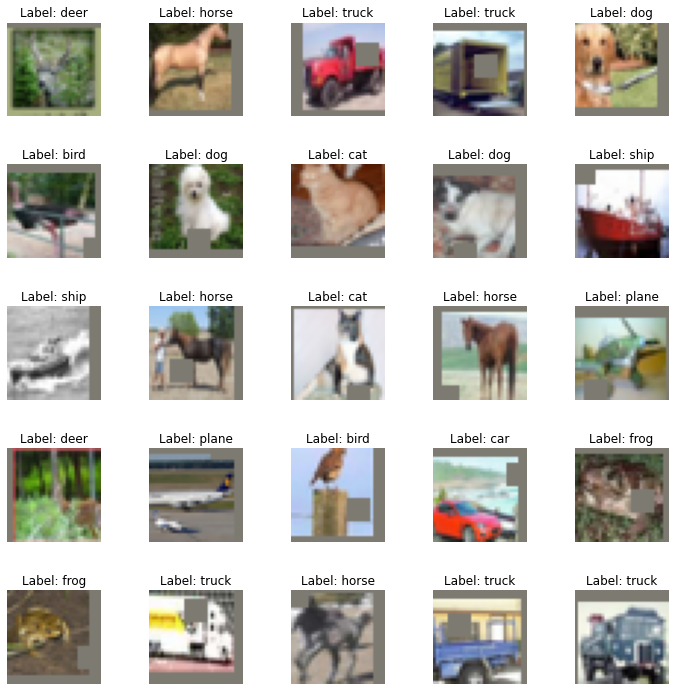

In [7]:
## view the sample images post transformation
utility.displayImageGridFromLoader(train_loader,classes)

## get the model

In [8]:
model = md(device).to(device)  # Create model

summary(model,input_size=(1,3, 32, 32))  # Display model summary

Layer (type:depth-idx)                   Output Shape              Param #
UltimusModel                             [1, 10]                   --
├─Sequential: 1-1                        [1, 48, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           448
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 32, 32]           32
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           4,640
│    └─ReLU: 2-5                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 32, 32]           64
│    └─Conv2d: 2-7                       [1, 48, 32, 32]           13,872
│    └─ReLU: 2-8                         [1, 48, 32, 32]           --
│    └─BatchNorm2d: 2-9                  [1, 48, 32, 32]           96
├─Sequential: 1-2                        [1, 48, 1, 1]             --
│    └─AdaptiveAvgPool2d: 2-10           [1, 48, 1, 1]             --
├─Seque

## Find out the LR using the Find LR

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.96E-01


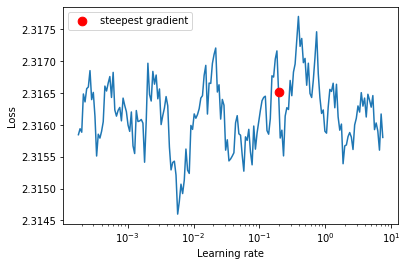

Max LR is 0.0057384416483023965
The final learning rate 0.0057384416483023965


In [10]:
## https://github.com/davidtvs/pytorch-lr-finder/blob/master/examples/lrfinder_cifar10.ipynb
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
## make a deep copy of the model ..this is a very important step
model_exp=copy.deepcopy(model)
ler_rate=main.find_lr(model_exp,optimizer,criterion,train_loader)

print("The final learning rate",ler_rate)

## Train the model

In [11]:
optimizer=optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=float(ler_rate),
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,## how much percent of cycle to use for building up
                                                div_factor=10,## initial learng rate max/div_factor
                                                three_phase=False, ## dont use the annihilation 
                                                final_div_factor=50,## the min rate =inital_lr/final_factor
                                                anneal_strategy='cos'## shape of the cycle
                                                )
net, history = trainer.fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0005738441648302393)


Batch_id=97 Loss=2.24390 Accuracy=12.48%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.79it/s]



Test set: Average loss: 2.0309, Accuracy: 1853/10000 (18.53%)

EPOCH: 2 (LR: 0.00110966145699197)


Batch_id=97 Loss=1.91373 Accuracy=20.04%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.09it/s]



Test set: Average loss: 1.9185, Accuracy: 2101/10000 (21.01%)

EPOCH: 3 (LR: 0.002494753181307849)


Batch_id=97 Loss=1.87484 Accuracy=21.48%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.77it/s]



Test set: Average loss: 1.8914, Accuracy: 2021/10000 (20.21%)

EPOCH: 4 (LR: 0.004154316674458137)


Batch_id=97 Loss=1.89989 Accuracy=21.96%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.92it/s]



Test set: Average loss: 1.9123, Accuracy: 2293/10000 (22.93%)

EPOCH: 5 (LR: 0.005399645550385868)


Batch_id=97 Loss=1.85189 Accuracy=24.03%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.94it/s]



Test set: Average loss: 1.9770, Accuracy: 2102/10000 (21.02%)

EPOCH: 6 (LR: 0.005736748085590433)


Batch_id=97 Loss=1.82455 Accuracy=25.53%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.96it/s]



Test set: Average loss: 2.0259, Accuracy: 2425/10000 (24.25%)

EPOCH: 7 (LR: 0.005682483999856224)


Batch_id=97 Loss=1.81886 Accuracy=26.06%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.93it/s]



Test set: Average loss: 1.8499, Accuracy: 2625/10000 (26.25%)

EPOCH: 8 (LR: 0.005553221563049445)


Batch_id=97 Loss=1.80417 Accuracy=26.67%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.87it/s]



Test set: Average loss: 1.8249, Accuracy: 2515/10000 (25.15%)

EPOCH: 9 (LR: 0.005352413806054755)


Batch_id=97 Loss=1.77990 Accuracy=27.48%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.03it/s]



Test set: Average loss: 1.8060, Accuracy: 2659/10000 (26.59%)

EPOCH: 10 (LR: 0.005085424973922068)


Batch_id=97 Loss=1.76763 Accuracy=28.11%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.94it/s]



Test set: Average loss: 1.8703, Accuracy: 2325/10000 (23.25%)

EPOCH: 11 (LR: 0.004759387228987069)


Batch_id=97 Loss=1.75747 Accuracy=28.69%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.07it/s]



Test set: Average loss: 2.1149, Accuracy: 2238/10000 (22.38%)

EPOCH: 12 (LR: 0.004383010127023542)


Batch_id=97 Loss=1.75368 Accuracy=28.92%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.69it/s]



Test set: Average loss: 2.4050, Accuracy: 2207/10000 (22.07%)

EPOCH: 13 (LR: 0.003966347955955051)


Batch_id=97 Loss=1.77461 Accuracy=27.65%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.12it/s]



Test set: Average loss: 1.8330, Accuracy: 2603/10000 (26.03%)

EPOCH: 14 (LR: 0.003520531152285107)


Batch_id=97 Loss=1.73175 Accuracy=29.39%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.82it/s]



Test set: Average loss: 1.7208, Accuracy: 2863/10000 (28.63%)

EPOCH: 15 (LR: 0.0030574689700089103)


Batch_id=97 Loss=1.71119 Accuracy=30.08%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.07it/s]



Test set: Average loss: 1.7123, Accuracy: 3064/10000 (30.64%)

EPOCH: 16 (LR: 0.002589531344711889)


Batch_id=97 Loss=1.70294 Accuracy=30.78%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.81it/s]



Test set: Average loss: 1.7144, Accuracy: 3082/10000 (30.82%)

EPOCH: 17 (LR: 0.002129218451326209)


Batch_id=97 Loss=1.68893 Accuracy=31.07%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.95it/s]



Test set: Average loss: 1.6704, Accuracy: 3226/10000 (32.26%)

EPOCH: 18 (LR: 0.001688826782759873)


Batch_id=97 Loss=1.67226 Accuracy=31.92%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.88it/s]



Test set: Average loss: 1.6584, Accuracy: 3216/10000 (32.16%)

EPOCH: 19 (LR: 0.001280120669552132)


Batch_id=97 Loss=1.66188 Accuracy=32.20%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.97it/s]



Test set: Average loss: 1.6524, Accuracy: 3252/10000 (32.52%)

EPOCH: 20 (LR: 0.0009140180153609797)


Batch_id=97 Loss=1.65026 Accuracy=32.50%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.89it/s]



Test set: Average loss: 1.7681, Accuracy: 3051/10000 (30.51%)

EPOCH: 21 (LR: 0.0006002986433361667)


Batch_id=97 Loss=1.63464 Accuracy=33.26%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.89it/s]



Test set: Average loss: 1.6954, Accuracy: 3131/10000 (31.31%)

EPOCH: 22 (LR: 0.0003473430444190433)


Batch_id=97 Loss=1.62671 Accuracy=33.37%: 100%|█████████████████████| 98/98 [00:06<00:00, 14.05it/s]



Test set: Average loss: 1.6572, Accuracy: 3190/10000 (31.90%)

EPOCH: 23 (LR: 0.0001619085064736229)


Batch_id=97 Loss=1.61712 Accuracy=33.83%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.76it/s]



Test set: Average loss: 1.6306, Accuracy: 3278/10000 (32.78%)

EPOCH: 24 (LR: 4.8948604586568715e-05)


Batch_id=97 Loss=1.61208 Accuracy=33.94%: 100%|█████████████████████| 98/98 [00:07<00:00, 13.97it/s]



Test set: Average loss: 1.6220, Accuracy: 3260/10000 (32.60%)



## plotting the results

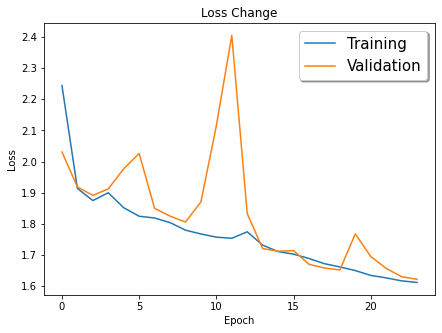

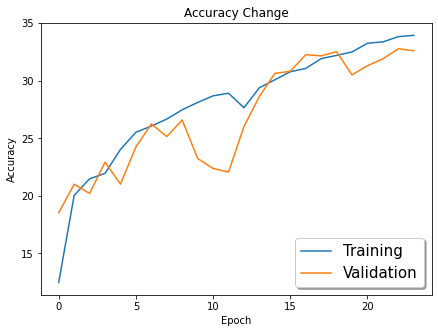

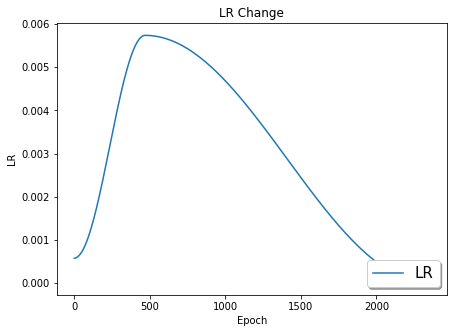

In [12]:
## get the data collected during the training of the model
train_accuracies, train_losses, test_accuracies, test_losses, lr_trend=history

utility.plot_metric({
    'Training': train_losses,
    'Validation':test_losses
}, 'Loss')

utility.plot_metric({
    'Training': train_accuracies,
    'Validation':test_accuracies
}, 'Accuracy')

utility.plot_metric({
    'LR': lr_trend
}, 'LR')


#utility.plotLossAccuracyCurve(train_losses,train_accuracies,test_losses,test_accuracies)

## now displaying the correct predictions and mispredictions

In [13]:
correct_samples,incorrect_samples=trainer.qualityCheck(model, test_loader, device, sample_count=25)

## missclassifications

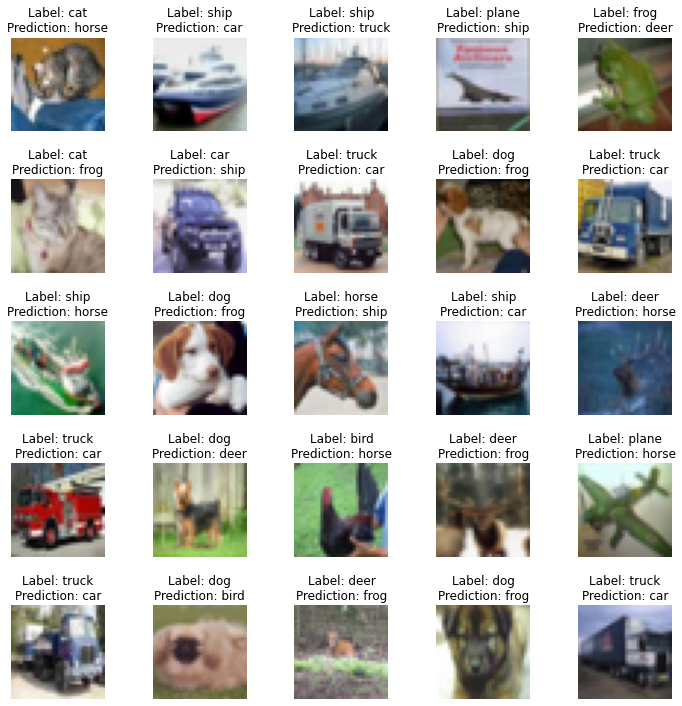

In [14]:
utility.save_and_show_result(incorrect_samples, classes)

## Correct Predictions

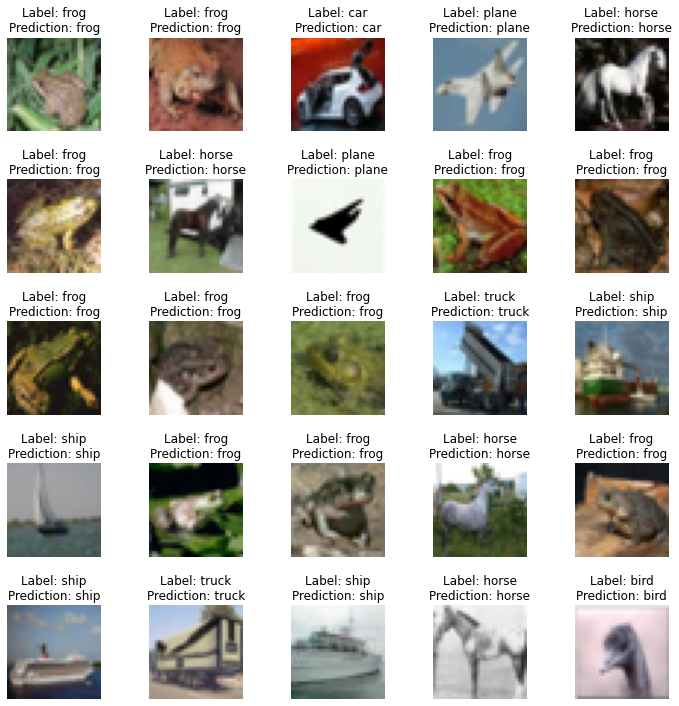

In [15]:
utility.save_and_show_result(correct_samples, classes)

## Class wise accuracy

In [16]:
main.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 41 %
Accuracy of   car : 66 %
Accuracy of  bird :  7 %
Accuracy of   cat :  7 %
Accuracy of  deer : 18 %
Accuracy of   dog :  0 %
Accuracy of  frog : 81 %
Accuracy of horse : 36 %
Accuracy of  ship : 41 %
Accuracy of truck : 24 %
